<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_5_DE_HPO_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 163kB 4.3MB/s 


In [2]:
#@title Defining Imports
#numpy
import numpy as np
#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#SkLearn
from sklearn.decomposition import PCA
#plotting
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
#utils
import random
import math
import array
import time

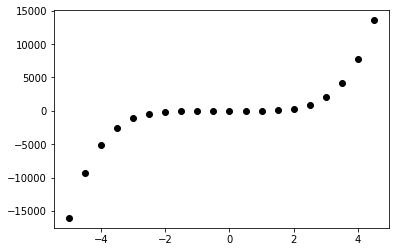

In [3]:
#@title Setup Target Function and Data
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10) 

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')

In [4]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)    
    self.fc2 = nn.Linear(middle,middle)    
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))     
    x = F.relu(self.fc2(x))    
    x = self.out(x)
    return x

In [5]:
#@title Define HyperparametersEC Class
class HyperparametersEC(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs) 
    self.hparms = [d for d in self.__dict__]  
        
  def __str__(self):
    out = ""
    for d in self.hparms:
      ds = self.__dict__[d]
      out += f"{d} = {ds} "
    return out   

  def values(self):
    vals = []
    for d in self.hparms:
      vals.append(self.__dict__[d])
    return vals

  def size(self):
    return len(self.hparms)

  def next(self, individual):
    dict = {}
    #initialize generators
    for i, d in enumerate(self.hparms):
      next(self.__dict__[d])
    for i, d in enumerate(self.hparms):      
      dict[d] = self.__dict__[d].send(individual[i])
    return HyperparametersEC(**dict)   

def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def linespace(min,max):
  rnge = max - min
  while True:
    i = yield
    i = (clamp(i, -1.0, 1.0) + 1.0) / 2.0
    yield i * rnge + min

def linespace_int(min,max):
  rnge = max - min
  while True:
    i = yield
    i = (clamp(i, -1.0, 1.0) + 1.0) / 2.0
    yield int(i * rnge) + min

def static(val):
  while True:
    yield val

# Create the HyperparamtersEC Object

In [6]:
#@title Instantiate the HPO
hp = HyperparametersEC(
  middle_layer = linespace_int(8, 64),
  learning_rate = linespace(3.5e-02,3.5e-01),
  batch_size = linespace_int(4,20),    
  epochs = linespace_int(50,400)  
)

ind = [-.5, -.3, -.1, .8]
print(hp.next(ind))

middle_layer = 22 learning_rate = 0.14525 batch_size = 11 epochs = 365 


In [7]:
#@title Check for Cuda/GPU
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Using CUDA


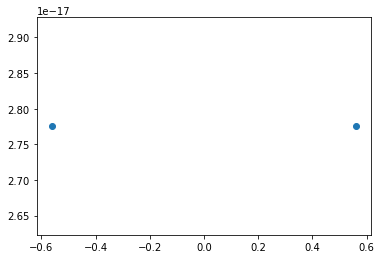

In [8]:
#@title Setup Principle Component Analysis
#create example individuals
pop = np.array([[-.5, .75, -.1, .8], [-.5, -.3, -.5, .8]])
pca = PCA(n_components=2)
reduced = pca.fit_transform(pop)

t = reduced.transpose()

plt.scatter(t[0], t[1])
plt.show()

[link text](https://)# Setup DEAP for DE Search

In [9]:
#@title DE Bounding Hyperparameters
NDIM = hp.size()
CR = 0.25
F_ = 1  
MU = 50
NGEN = 10  

In [10]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

In [11]:
#@title Add Genetic Operators to Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selRandom, k=3)

# Create a Training Function

1892.699462890625


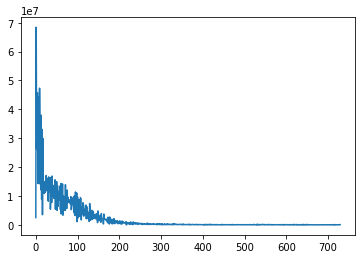

In [12]:
#@title Wrapper Function for DL
loss_fn = nn.MSELoss()
if cuda:
  loss_fn.cuda()

def train_function(hp):   
  X = np.reshape(
      np.arange(
          data_min, 
          data_max, 
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]
  
  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)
  
  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)  
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
  if cuda:
    model.cuda()
      
  history=[]  
  start = time.time()
  for i in range(hp.epochs):        
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X).type(Tensor))
      y_batch = Variable(torch.Tensor(y).type(Tensor))                   
      # forward pass
      y_pred = model(x_batch)        
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)  
      ll = loss.data
      history.append(ll)                   
      # reset gradients
      optimizer.zero_grad()        
      # backwards pass
      loss.backward()        
      # step the optimizer - update the weights
      optimizer.step()  
  end = time.time() - start
  return end, history, model, hp

hp_in = hp.next(ind)
span, history, model, hp_out = train_function(hp_in)
plt.plot(history)
print(min(history).item())

# DE Evaluate Function in Toolbox

In [13]:
#@title Create Evaluation Function and Register
run_history = []

def evaluate(individual):
  hp_in = hp.next(individual)
  span, history, model, hp_out = train_function(hp_in)
  y_ = model(torch.Tensor(Xi).type(Tensor))  
  fitness = loss_fn(y_, torch.Tensor(yi).type(Tensor)).data.item()  
  run_history.append([fitness,*hp_out.values()]) 
  return fitness, 

# fitness eval
toolbox.register("evaluate", evaluate)

# Perform the HPO

In [ ]:
random.seed(64)
    
pop = toolbox.population(n=MU);
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

# Evaluate the individuals
fitnesses = toolbox.map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

record = stats.compile(pop)
logbook.record(gen=0, evals=len(pop), **record)
print(logbook.stream)
start = time.time()
for g in range(1, NGEN):
  for k, agent in enumerate(pop):
    a,b,c = toolbox.select(pop)
    y = toolbox.clone(agent)
    index = random.randrange(NDIM)
    for i, value in enumerate(agent):
      if i == index or random.random() < CR:
        y[i] = a[i] + F_*(b[i]-c[i])
    y.fitness.values = toolbox.evaluate(y)
    if y.fitness > agent.fitness:
      pop[k] = y            
  hof.update(pop)    
  record = stats.compile(pop)
  #logbook.record(gen=g, evals=len(pop), **record)
  best = hof[0]

  span, history, model, hp_out = train_function(hp.next(best))
  y_ = model(torch.Tensor(Xi).type(Tensor))  
  fitness = loss_fn(y_, torch.Tensor(yi).type(Tensor)).data.item()     
  run_history.append([fitness,*hp_out.values()]) 
  best_hp = hp_out

  clear_output()    
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))    
  fig.suptitle(f"Best Fitness {best.fitness} \n{best_hp}")
  fig.text(0,0,f"Generation {g+1}/{NGEN} Current Fitness {fitness} \n{hp_out}")
  ax1.plot(history)
  ax1.set_xlabel("iteration") 
  ax1.set_ylabel("loss")

  ax2.plot(Xi, yi, 'o', color='black') 
  ax2.plot(Xi,y_.detach().cpu().numpy(), 'r') 
  ax2.set_xlabel("X") 
  ax2.set_ylabel("Y")
   
  rh = np.array(run_history) 
  M = rh[:,1:NDIM+1]      
  reduced = pca.fit_transform(M)
  t = reduced.transpose() 
  hexbins = ax3.hexbin(t[0], t[1], C=rh[:, 0], 
                        bins=50, gridsize=50, cmap=cm.get_cmap('gray'))
  ax3.set_xlabel("PCA X")
  ax3.set_ylabel("PCA Y")    
      
  plt.show()
  time.sleep(1)  